In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times

from utils import (
    load_4th_wave_data,
    plot_new_hosped,
    log_normal_int_dist,
    plot_lognormal_dist,
    generate_los_data
)

# Simulation parameters

In [2]:
START_DAY = 14 # day at which to start calculating LOS

# distribution simulated parameters - a lognormal
LN_MEAN=10
LN_STD=10
MAX_VAL = 50

SEED = 42
np.random.seed(SEED)

# Generate simulated data  

Let's download data on new severe hospitalized during the 4th wave

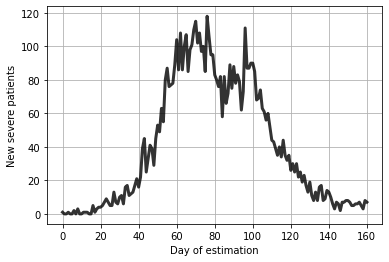

In [3]:
times, new_hosped = load_4th_wave_data()
plot_new_hosped(times, new_hosped)

For Length of Stay (LOS) lets simulate from a fake distribution, somewhat resembling the literature  

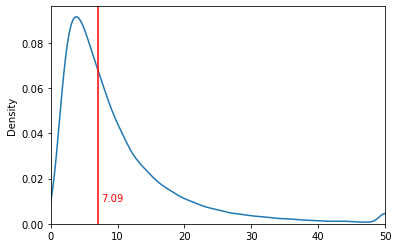

In [4]:
true_median = plot_lognormal_dist(LN_MEAN, LN_STD, max_val=MAX_VAL)

True (generating process) median LOS is ~ 7.07

Now let's generate a data table

In [5]:
data = generate_los_data(LN_MEAN, LN_STD, MAX_VAL, new_hosped)
data.head()

,t_adm,los,t_release
0,0,16.677121,16.677121
1,3,2.702333,5.702333
2,6,11.416896,17.416896
3,6,4.222645,10.222645
4,8,5.383996,13.383996


Now we have data, let's try a few methods to estimate median LOS  

# Kaplan-Meier

To do this, we need to transform data to the correct format for survival analysis (duration and event column, taking censoring into account)  
We run a sliding window whose right edge is the "current time", so all information that happened before that time is available to us

In [6]:
def km_median_survival_time_estimate(data, current_t):
    # filter only ids that have admission before current_t
    df = data[data["t_adm"] <= current_t].copy()

    # prep survival columns for Uncensored individuals
    idx_uncensored = df["t_release"] <= current_t
    df.loc[idx_uncensored, "T"] = df.loc[idx_uncensored, "los"]
    df.loc[idx_uncensored, "E"] = 1

    # prep survival columns for Censored individuals
    idx_censored = df["t_release"] > current_t
    df.loc[idx_censored, "T"] = current_t - df.loc[idx_censored, "t_adm"]
    df.loc[idx_censored, "E"] = 0

    # Fit KM
    kmf = KaplanMeierFitter()
    kmf.fit(df["T"], df["E"])

    # Optional future CIs
    # median_ci = median_survival_times(kmf.confidence_interval_)

    return kmf.median_survival_time_


km_median_los_7day = np.zeros_like(times, dtype=float)

for current_t in times[START_DAY:]:
    km_median_los_7day[current_t] = km_median_survival_time_estimate(data, current_t)


# Naive estimation  

Example when estimating based on all available data on released patients up to current time, not taking censoring into account.

In [7]:
def naive_median_survival_time_estimate(data, current_t):
    # filter only ids that have admission before current_t
    df = data[data["t_adm"]<=current_t].copy()
    # now choose only released patients (naively)
    df = df[df["t_release"]<=current_t]
    # calc los
    return df['los'].median()


naive_median_los_7day = np.zeros_like(times, dtype=float)

for current_t in times[START_DAY:]:
    naive_median_los_7day[current_t] = naive_median_survival_time_estimate(data, current_t)

# Methods comparison - estimation of median LOS

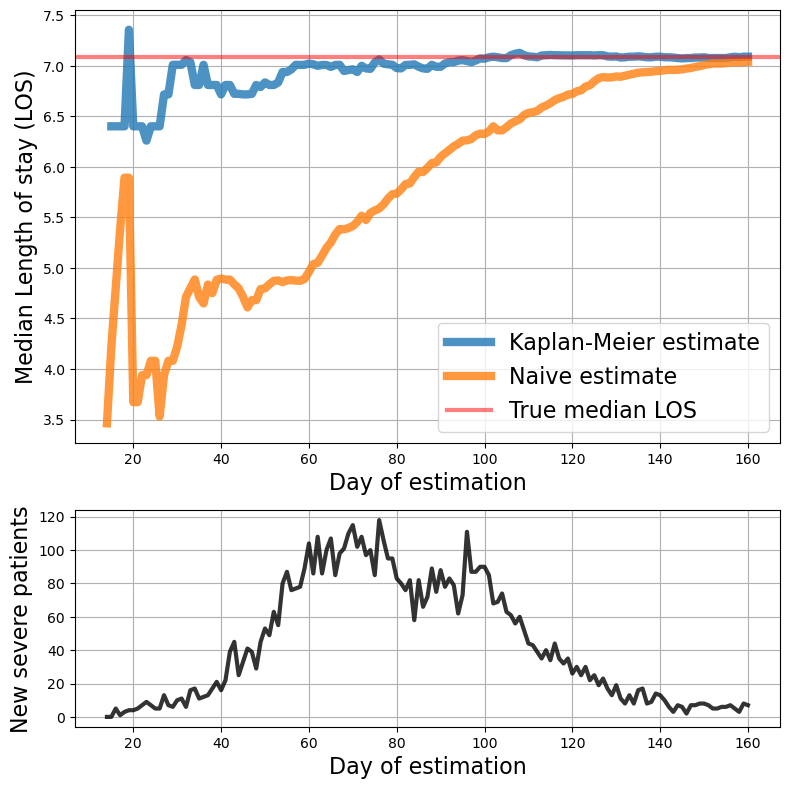

In [8]:
fig , axes = plt.subplots(2,1, figsize=(8,8), dpi=100, gridspec_kw={'height_ratios': [2, 1]})
sz = 16

ax = axes[0]
ax.plot(times[START_DAY:],km_median_los_7day[START_DAY:], label='Kaplan-Meier estimate', lw=6, alpha=0.8)
ax.plot(times[START_DAY:],naive_median_los_7day[START_DAY:], label='Naive estimate', lw=6, alpha=0.8)
ax.axhline(true_median,label='True median LOS', color='r', ls='-', lw=3, alpha=0.5)
ax.set_ylabel('Median Length of stay (LOS)', fontsize=sz)
ax.set_xlabel('Day of estimation', fontsize=sz)
ax.legend(fontsize=sz)
ax.grid()

ax = axes[1]
ax.plot(times[START_DAY:], new_hosped[START_DAY:], color='k', lw=3, alpha=0.8, label='New severe patients')
ax.set_ylabel('New severe patients', fontsize=sz)
ax.set_xlabel('Day of estimation', fontsize=sz)
ax.grid()

fig.tight_layout()
fig.savefig('median_LOS_summary.png', dpi=100)

So we can clearly see that the naive estimate is biased and estimates shorter LOS, only stabilizing at the end of the wave.  
While the KM estimator stabilizes wuickly after a few days to the true LOS. 
Estimating LOS needs to take right censoring into account.